# Classification. Linear models and KNN

In [293]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [294]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import missingno as mssno
% matplotlib inline

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [295]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [296]:
insurance_data = pd.read_csv('/content/drive/MyDrive/Courses/RS School ML/ml-intro-2021/5_classification_linear_knn/porto_data/train.csv').set_index('id')

In [297]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [298]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [299]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [300]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [301]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [302]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

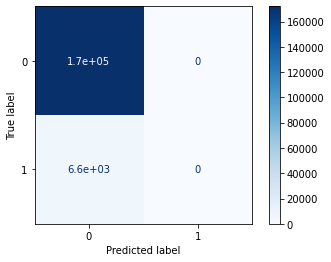

In [303]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [304]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.551102,8.295933,0.829931,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.793506,2.508270,0.375716,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.720677,7.000000,1.000000,-1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,2.000000,1.000000,65.000000,3.000000,0.374166,0.765811,0.368

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

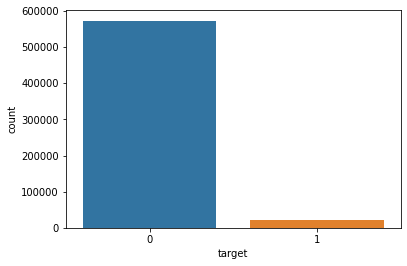

In [305]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [306]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

Коэффициент Джини - это площадь фигуры, зажатой между прямой абсолютного равенства(получается, если предсказать все классы одинаковыми) и Lift curve.
\begin{equation} 
Gini_{normalized} =  \frac{Gini_{model}}{Gini_{perfect}}
\end{equation}
, где $Gini_{model}$ - коэффициент Джини для нашей модели, $Gini_{perfect}$ - коэффициент Джини для идеальной модели.

Пусть $S =  \big\{s_{1}, ... , s_{k}\big\}$, где $s_{1} < ... < s_{k}$ - вероятностное распределение значений, которые прогнозирует модель. $S_{n_{1}}$ - множество значений, которые принимают объекты $n_{1}$ и $S_{n_{1}}  \subseteq S $.  $S_{n_{0}}$ - множество значений, которые принимают объекты $n_{0}$ и $S_{n_{0}}  \subseteq S $.

Пусть $p^{i}_{n_{0}}$ и $p^{i}_{n_{1}}$ - это вероятности того, что объекты $n_{0}$ и $n_{1}$ соответственно примут значение $s_{i}$. То есть
\begin{equation}
\sum_{i=1}^{k} p^{i}_{n_{0}} = 1, \sum_{i=1}^{k} p^{i}_{n_{1}} = 1
\end{equation}
Если мы знаем $\pi$ - априорную вероятность для каждого объекта выборки, то можем найти вероятность того, что объект примет значение $s_{i}$ :
\begin{equation}
p^{i}_{n} = \pi p^{i}_{n_{0}} + (1 - \pi)p^{i}_{n_{1}}
\end{equation}
Зададим функцию распределения для объектов класса 1, класса 0 и для всех объектов выборки:
\begin{equation}
CDF^{i}_{n_{1}} = \sum_{j=1}^{i} p^{i}_{n_{1}}
\end{equation}
\begin{equation}
CDF^{i}_{n_{0}} = \sum_{j=1}^{i} p^{i}_{n_{0}}
\end{equation}
\begin{equation}
CDF^{i}_{n} = \sum_{j=1}^{i} p^{i}_{n}
\end{equation}
, где $i = 1, ... , k$

Чтобы решить задачу из прошлого теста про дефектные пары, нужно было доказать, что
\begin{equation} 
AUCROC =  \frac{\sum_{i=1}^{n_{1}} \sum_{j=1}^{n_{0}} S(x_{i}, x_{j}) }{n_{1} n_{2}} 
\end{equation}

\begin{equation} 
S(x_{i}, x_{j}) = \begin{cases}1, & x_{i} > x_{j}\\ \frac{1}{2},  & x_{i} = x_{j}\\0, & x_{i} < x_{j}\end{cases} 
\end{equation}
где $x_{i}$ -  ответ алгоритма на i-ом объекте из распределения «1», $x_{j}$ -  ответ алгоритма на j-ом объекте из распределения «0».


Формулу AUCROC можно записать в вероятностном виде:
\begin{equation}
AUCROC = P(S_{n_{1}} > S_{n_{1}}) +  \frac{1}{2} P(S_{n_{1}} = S_{n_{1}}) = \sum_{i=1}^{k} P(S_{n_{1}}  \geq  s_{i-1}) P(S_{n_{0}} = s_{i}) + \frac{1}{2} \sum_{i=1}^{k} P(S_{n_{1}}  =  s_{i}) P(S_{n_{0}} = s_{i}) = \sum_{i=1}^{k} (P(S_{n_{1}} \geq s_{i-1}) + \frac{1}{2}P(S_{n_{1}} = s_{i})) P(S_{n_{0}} = s_{i}) = \sum_{i=1}^{k} \frac{1}{2} (P(S_{n_{1}} \geq s_{i}) + P(S_{n_{1}} \geq s_{i-1}))P(S_{n_{0}} = s_{i}) = \sum_{i=1}^{k} \frac{1}{2} (CDF^{i}_{n_{1}} + CDF^{i-1}_{n_{1}}) (CDF^{i}_{n_{0}} - CDF^{i-1}_{n_{0}})
\end{equation}

Площадь под Lift кривой - это 0.5(нижняя половина) + коэффициент Джини для модели:
\begin{equation}
AUCLift = Gini_{model} + 0.5 = \sum_{i=1}^{k}  \frac{1}{2} (CDF^{i}_{n_{1}} + CDF^{i-1}_{n_{1}})(CDF^{i}_{n} - CDF^{i-1}_{n}) = \sum_{i=1}^{k}  \frac{1}{2} (CDF^{i}_{n_{1}} + CDF^{i-1}_{n_{1}})(\pi (CDF^{i}_{n_{1}} - CDF^{i-1}_{n_{1}}) + (1 - \pi)(CDF^{i}_{n_{0}} - CDF^{i-1}_{n_{0}})) = (1 - \pi)\sum_{i=1}^{k}  \frac{1}{2} (CDF^{i}_{n_{1}} + CDF^{i-1}_{n_{1}})(CDF^{i}_{n_{0}} - CDF^{i-1}_{n_{0}}) + \pi \sum_{i=1}^{k}  \frac{1}{2} (CDF^{i}_{n_{1}} + CDF^{i-1}_{n_{1}})(CDF^{i}_{n_{1}} - CDF^{i-1}_{n_{1}}) = (1 - \pi) AUCROC + \frac{1}{2} \pi \sum_{i=1}^{k}((CDF^{i}_{n_{1}})^2 - (CDF^{i-1}_{n_{0}})^2) = (1 - \pi) AUCROC + \frac{1}{2} \pi
\end{equation}
Джини для идеальной модели:
\begin{equation}
Gini_{perfect} = \frac{1}{2} (1 - \pi)
\end{equation}
То есть:
\begin{equation}
Gini_{normalized} = \frac{Gini_{model}}{Gini_{perfect}}  = \frac{(1 - \pi)AUCROC + \frac{1}{2} }{\frac{1}{2} (1 - \pi)} = 2AUCROC - 1
\end{equation}

Есть второй способ доказательства:
1)найти площадь под ROC curve с помощью интеграла
2)Найти площадь под Lift curve с помощью интеграла и вычесть 0.5
3)подставить все в $Gini_{normalized}$


**(0.5 points)** By the way, what other metrics could you suggest for this problem?

Т.к. нормализованный Джини зависит только от rocauc, то rocauc тоже сойдет.
Возможно,F-мера с каким-нибудь оптимальным $\beta$.

Let's calculate the Normalized Gini Coefficient:

In [307]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [308]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [309]:
train = pd.read_csv('/content/drive/MyDrive/Courses/RS School ML/ml-intro-2021/5_classification_linear_knn/porto_data/train.csv', na_values=-1)
test = pd.read_csv('/content/drive/MyDrive/Courses/RS School ML/ml-intro-2021/5_classification_linear_knn/porto_data/test.csv', na_values=-1)

In [310]:
train.head(5)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10.0,1.0,NaN,0,1.0,4,1.0,0,0.0,1,12,2.0,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11.0,1.0,NaN,0,NaN,11,1.0,1,2.0,1,19,3.0,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,NaN,7.0,1.0,NaN,0,NaN,14,1.0,1,2.0,1,60,1.0,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7.0,1.0,0.0,0,1.0,11,1.0,1,3.0,1,104,1.0,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11.0,1.0,NaN,0,NaN,14,1.0,1,2.0,1,82,3.0,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [311]:
train.target.value_counts()

0    573518
1     21694
Name: target, dtype: int64

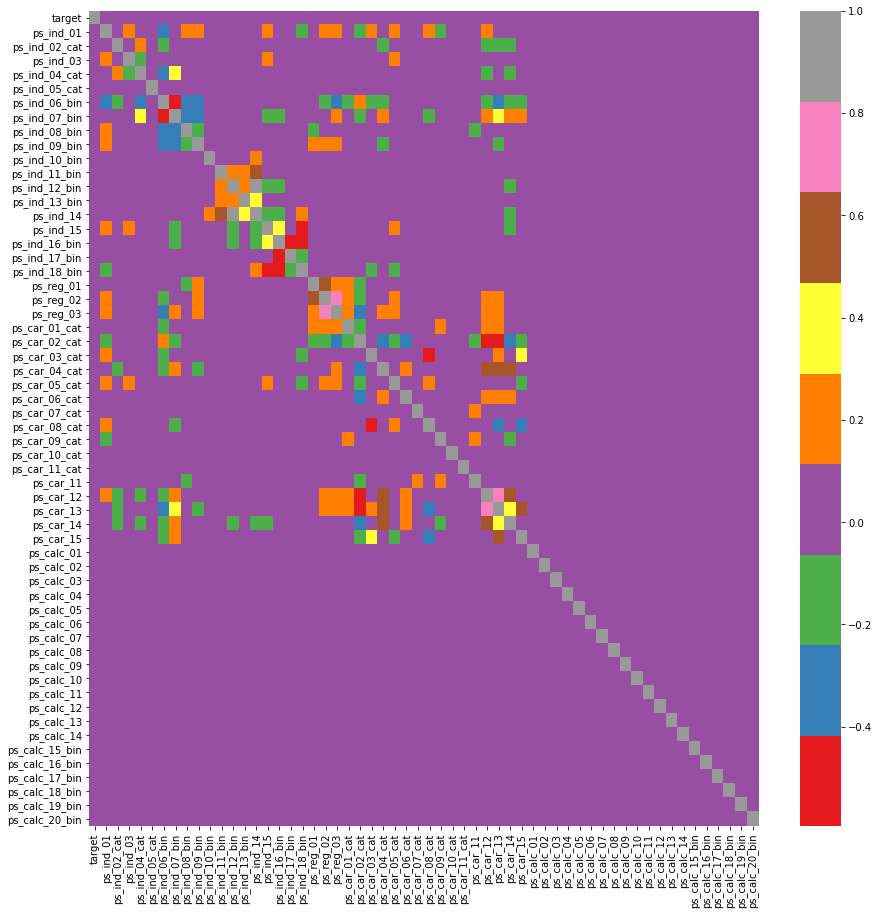

In [312]:
plt.figure(figsize=(15,15))
sns.heatmap(train.drop('id',axis=1).corr(), cmap='Set1')

In [313]:
train.shape, test.shape

((595212, 59), (892816, 58))

In [314]:
train.columns.str.startswith('ps_calc')

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [315]:
train.drop(train.columns[train.columns.str.startswith('ps_calc')], axis=1, inplace=True)
test.drop(test.columns[test.columns.str.startswith('ps_calc')], axis=1, inplace=True)
train.shape, test.shape

((595212, 39), (892816, 38))

Посмотрим на пропущенные значения

In [316]:
train.isnull().mean().sort_values(ascending = False)[:15]

ps_car_03_cat    0.690898
ps_car_05_cat    0.447825
ps_reg_03        0.181065
ps_car_14        0.071605
ps_car_07_cat    0.019302
ps_ind_05_cat    0.009760
ps_car_09_cat    0.000956
ps_ind_02_cat    0.000363
ps_car_01_cat    0.000180
ps_ind_04_cat    0.000139
ps_car_11        0.000008
ps_car_02_cat    0.000008
ps_car_12        0.000002
ps_ind_07_bin    0.000000
ps_ind_09_bin    0.000000
dtype: float64

In [317]:
test.isnull().mean().sort_values(ascending = False)[:15]

ps_car_03_cat    0.690972
ps_car_05_cat    0.448423
ps_reg_03        0.181094
ps_car_14        0.071465
ps_car_07_cat    0.019412
ps_ind_05_cat    0.009756
ps_car_09_cat    0.000982
ps_ind_02_cat    0.000344
ps_car_01_cat    0.000179
ps_ind_04_cat    0.000162
ps_car_02_cat    0.000006
ps_car_11        0.000001
ps_ind_11_bin    0.000000
ps_ind_10_bin    0.000000
ps_ind_09_bin    0.000000
dtype: float64

ЗАменим пропуски наиболее часто встречающимися значениями

In [318]:
for column in train.columns:
  if train[column].isnull().sum() > 0:
    train[column].fillna(train[column].mode()[0], inplace=True)

In [319]:
for column in test.columns:
  if test[column].isnull().sum() > 0:
    test[column].fillna(test[column].mode()[0], inplace=True)

In [320]:
train.dtypes

id                 int64
target             int64
ps_ind_01          int64
ps_ind_02_cat    float64
ps_ind_03          int64
ps_ind_04_cat    float64
ps_ind_05_cat    float64
ps_ind_06_bin      int64
ps_ind_07_bin      int64
ps_ind_08_bin      int64
ps_ind_09_bin      int64
ps_ind_10_bin      int64
ps_ind_11_bin      int64
ps_ind_12_bin      int64
ps_ind_13_bin      int64
ps_ind_14          int64
ps_ind_15          int64
ps_ind_16_bin      int64
ps_ind_17_bin      int64
ps_ind_18_bin      int64
ps_reg_01        float64
ps_reg_02        float64
ps_reg_03        float64
ps_car_01_cat    float64
ps_car_02_cat    float64
ps_car_03_cat    float64
ps_car_04_cat      int64
ps_car_05_cat    float64
ps_car_06_cat      int64
ps_car_07_cat    float64
ps_car_08_cat      int64
ps_car_09_cat    float64
ps_car_10_cat      int64
ps_car_11_cat      int64
ps_car_11        float64
ps_car_12        float64
ps_car_13        float64
ps_car_14        float64
ps_car_15        float64
dtype: object

In [321]:
train.nunique()

id               595212
target                2
ps_ind_01             8
ps_ind_02_cat         4
ps_ind_03            12
ps_ind_04_cat         2
ps_ind_05_cat         7
ps_ind_06_bin         2
ps_ind_07_bin         2
ps_ind_08_bin         2
ps_ind_09_bin         2
ps_ind_10_bin         2
ps_ind_11_bin         2
ps_ind_12_bin         2
ps_ind_13_bin         2
ps_ind_14             5
ps_ind_15            14
ps_ind_16_bin         2
ps_ind_17_bin         2
ps_ind_18_bin         2
ps_reg_01            10
ps_reg_02            19
ps_reg_03          5012
ps_car_01_cat        12
ps_car_02_cat         2
ps_car_03_cat         2
ps_car_04_cat        10
ps_car_05_cat         2
ps_car_06_cat        18
ps_car_07_cat         2
ps_car_08_cat         2
ps_car_09_cat         5
ps_car_10_cat         3
ps_car_11_cat       104
ps_car_11             4
ps_car_12           183
ps_car_13         70482
ps_car_14           849
ps_car_15            15
dtype: int64

In [322]:
train_uniq_dtype = pd.DataFrame()
train_uniq_dtype['unic values'] = train.nunique()
train_uniq_dtype['dtype'] = train.dtypes
train_uniq_dtype

,unic values,dtype
id,595212,int64
target,2,int64
ps_ind_01,8,int64
ps_ind_02_cat,4,float64
ps_ind_03,12,int64
ps_ind_04_cat,2,float64
ps_ind_05_cat,7,float64
ps_ind_06_bin,2,int64
ps_ind_07_bin,2,int64
ps_ind_08_bin,2,int64


In [323]:
test_uniq_dtype = pd.DataFrame()
test_uniq_dtype['unic values'] = test.nunique()
test_uniq_dtype['dtype'] = test.dtypes
test_uniq_dtype

,unic values,dtype
id,892816,int64
ps_ind_01,8,int64
ps_ind_02_cat,4,float64
ps_ind_03,12,int64
ps_ind_04_cat,2,float64
ps_ind_05_cat,7,float64
ps_ind_06_bin,2,int64
ps_ind_07_bin,2,int64
ps_ind_08_bin,2,int64
ps_ind_09_bin,2,int64


In [324]:
train_uniq_dtype['unic values'] - test_uniq_dtype['unic values']

id              -297604.0
ps_car_01_cat         0.0
ps_car_02_cat         0.0
ps_car_03_cat         0.0
ps_car_04_cat         0.0
ps_car_05_cat         0.0
ps_car_06_cat         0.0
ps_car_07_cat         0.0
ps_car_08_cat         0.0
ps_car_09_cat         0.0
ps_car_10_cat         0.0
ps_car_11             0.0
ps_car_11_cat         0.0
ps_car_12           -18.0
ps_car_13        -13287.0
ps_car_14           -35.0
ps_car_15             0.0
ps_ind_01             0.0
ps_ind_02_cat         0.0
ps_ind_03             0.0
ps_ind_04_cat         0.0
ps_ind_05_cat         0.0
ps_ind_06_bin         0.0
ps_ind_07_bin         0.0
ps_ind_08_bin         0.0
ps_ind_09_bin         0.0
ps_ind_10_bin         0.0
ps_ind_11_bin         0.0
ps_ind_12_bin         0.0
ps_ind_13_bin         0.0
ps_ind_14             0.0
ps_ind_15             0.0
ps_ind_16_bin         0.0
ps_ind_17_bin         0.0
ps_ind_18_bin         0.0
ps_reg_01             0.0
ps_reg_02             0.0
ps_reg_03           -33.0
target      

Заменим тип фич с int и с float(где уникальных значений не слишком много) на категориальный

In [325]:
for column in train.columns:
  if train[column].nunique() < 105:
    train[column] = train[column].astype('category')

for column in test.columns:
  if test[column].nunique() < 105:
    test[column] = test[column].astype('category')

In [326]:
train.dtypes

id                  int64
target           category
ps_ind_01        category
ps_ind_02_cat    category
ps_ind_03        category
ps_ind_04_cat    category
ps_ind_05_cat    category
ps_ind_06_bin    category
ps_ind_07_bin    category
ps_ind_08_bin    category
ps_ind_09_bin    category
ps_ind_10_bin    category
ps_ind_11_bin    category
ps_ind_12_bin    category
ps_ind_13_bin    category
ps_ind_14        category
ps_ind_15        category
ps_ind_16_bin    category
ps_ind_17_bin    category
ps_ind_18_bin    category
ps_reg_01        category
ps_reg_02        category
ps_reg_03         float64
ps_car_01_cat    category
ps_car_02_cat    category
ps_car_03_cat    category
ps_car_04_cat    category
ps_car_05_cat    category
ps_car_06_cat    category
ps_car_07_cat    category
ps_car_08_cat    category
ps_car_09_cat    category
ps_car_10_cat    category
ps_car_11_cat    category
ps_car_11        category
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_car_15   

Посмотрим на фичи с "_cat"

In [327]:
cat_features= [col for col in train.columns if '_cat' in col]
cat_features

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


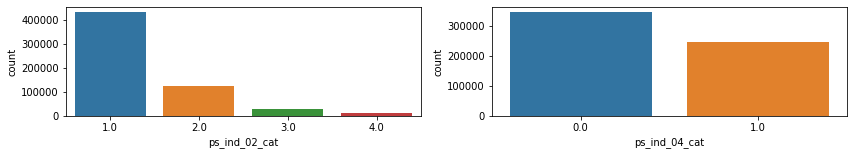

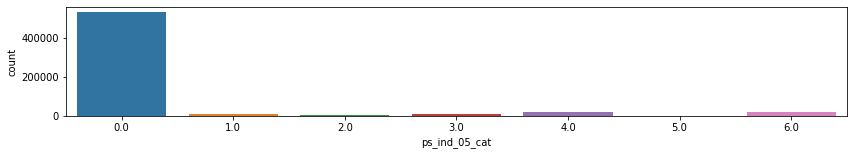

In [328]:
fig ,ax = plt.subplots(1,2,figsize=(14,2))
ax1,ax2, = ax.flatten()
sns.countplot(train['ps_ind_02_cat'], ax=ax1)
sns.countplot(train['ps_ind_04_cat'], ax=ax2)
fig,ax = plt.subplots(figsize=(14,2))
sns.countplot(train['ps_ind_05_cat'], ax=ax)



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


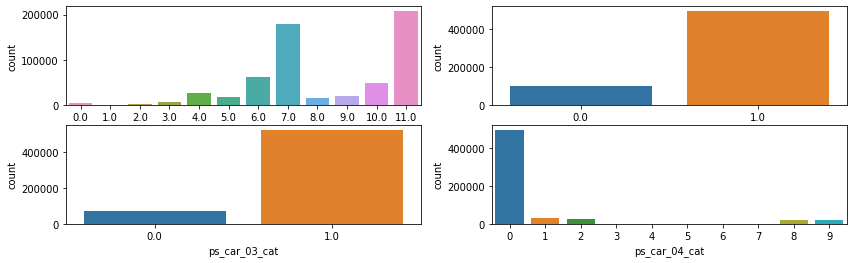

In [329]:
fig,ax = plt.subplots(2,2,figsize=(14,4))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.countplot(train['ps_car_01_cat'], ax=ax1)
sns.countplot(train['ps_car_02_cat'], ax=ax2)
sns.countplot(train['ps_car_03_cat'], ax=ax3)
sns.countplot(train['ps_car_04_cat'], ax=ax4)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


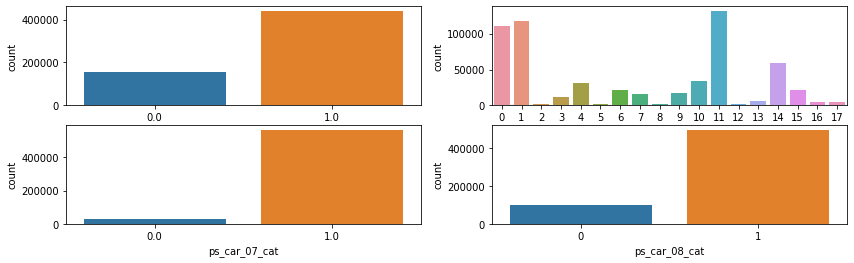

In [330]:
fig,ax = plt.subplots(2,2,figsize = (14,4))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.countplot(train['ps_car_05_cat'], ax=ax1)
sns.countplot(train['ps_car_06_cat'], ax=ax2)
sns.countplot(train['ps_car_07_cat'], ax=ax3)
sns.countplot(train['ps_car_08_cat'], ax=ax4)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


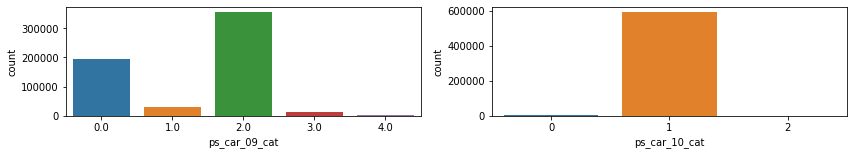

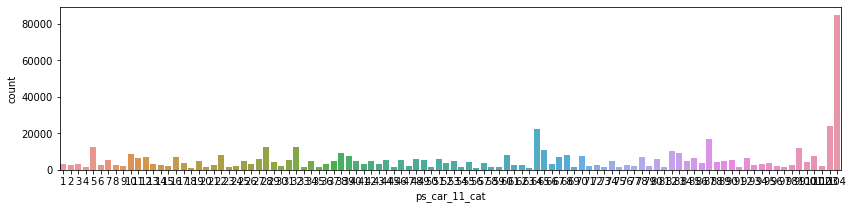

In [331]:
fig, ax = plt.subplots(1,2,figsize=(14,2))
ax1,ax2 = ax.flatten()
sns.countplot(train['ps_car_09_cat'], ax=ax1)
sns.countplot(train['ps_car_10_cat'], ax=ax2)
fig,ax = plt.subplots(figsize=(14,3))
sns.countplot(train['ps_car_11_cat'], ax=ax)

In [332]:
bin_features = [col for col in train.columns if 'bin' in col]
bin_features

['ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


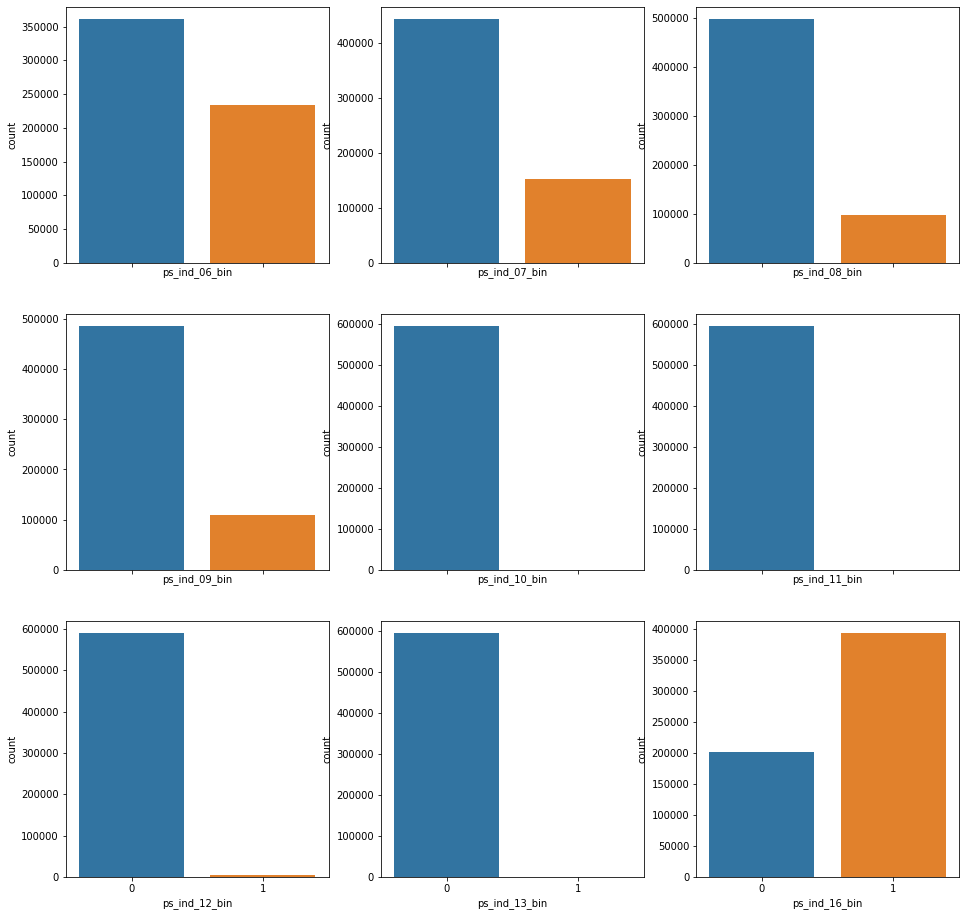

In [333]:
fig,ax = plt.subplots(3, 3, figsize=(16,16), sharex='all')
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9 = ax.flatten()
sns.countplot(train['ps_ind_06_bin'], ax=ax1)
sns.countplot(train['ps_ind_07_bin'], ax=ax2)
sns.countplot(train['ps_ind_08_bin'], ax=ax3)
sns.countplot(train['ps_ind_09_bin'], ax=ax4)
sns.countplot(train['ps_ind_10_bin'], ax=ax5)
sns.countplot(train['ps_ind_11_bin'], ax=ax6)
sns.countplot(train['ps_ind_12_bin'], ax=ax7)
sns.countplot(train['ps_ind_13_bin'], ax=ax8)
sns.countplot(train['ps_ind_16_bin'], ax=ax9)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


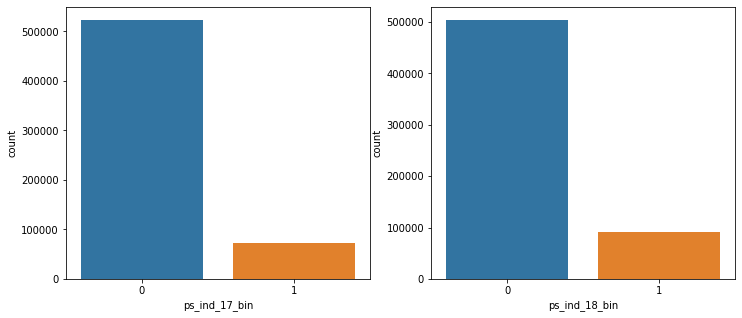

In [334]:
fig,ax = plt.subplots(1, 2, figsize=(12,5))
ax1,ax2 = ax.flatten()
sns.countplot(train['ps_ind_17_bin'], ax=ax1)
sns.countplot(train['ps_ind_18_bin'], ax=ax2)

In [335]:
train.dtypes

id                  int64
target           category
ps_ind_01        category
ps_ind_02_cat    category
ps_ind_03        category
ps_ind_04_cat    category
ps_ind_05_cat    category
ps_ind_06_bin    category
ps_ind_07_bin    category
ps_ind_08_bin    category
ps_ind_09_bin    category
ps_ind_10_bin    category
ps_ind_11_bin    category
ps_ind_12_bin    category
ps_ind_13_bin    category
ps_ind_14        category
ps_ind_15        category
ps_ind_16_bin    category
ps_ind_17_bin    category
ps_ind_18_bin    category
ps_reg_01        category
ps_reg_02        category
ps_reg_03         float64
ps_car_01_cat    category
ps_car_02_cat    category
ps_car_03_cat    category
ps_car_04_cat    category
ps_car_05_cat    category
ps_car_06_cat    category
ps_car_07_cat    category
ps_car_08_cat    category
ps_car_09_cat    category
ps_car_10_cat    category
ps_car_11_cat    category
ps_car_11        category
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_car_15   

In [336]:
category_columns = list(train.select_dtypes(include=['category']).columns)
category_columns

['target',
 'ps_ind_01',
 'ps_ind_02_cat',
 'ps_ind_03',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat',
 'ps_car_11',
 'ps_car_15']

In [337]:
category_not_catbin = [col for col in category_columns if col not in cat_features + bin_features]
category_not_catbin

['target',
 'ps_ind_01',
 'ps_ind_03',
 'ps_ind_14',
 'ps_ind_15',
 'ps_reg_01',
 'ps_reg_02',
 'ps_car_11',
 'ps_car_15']

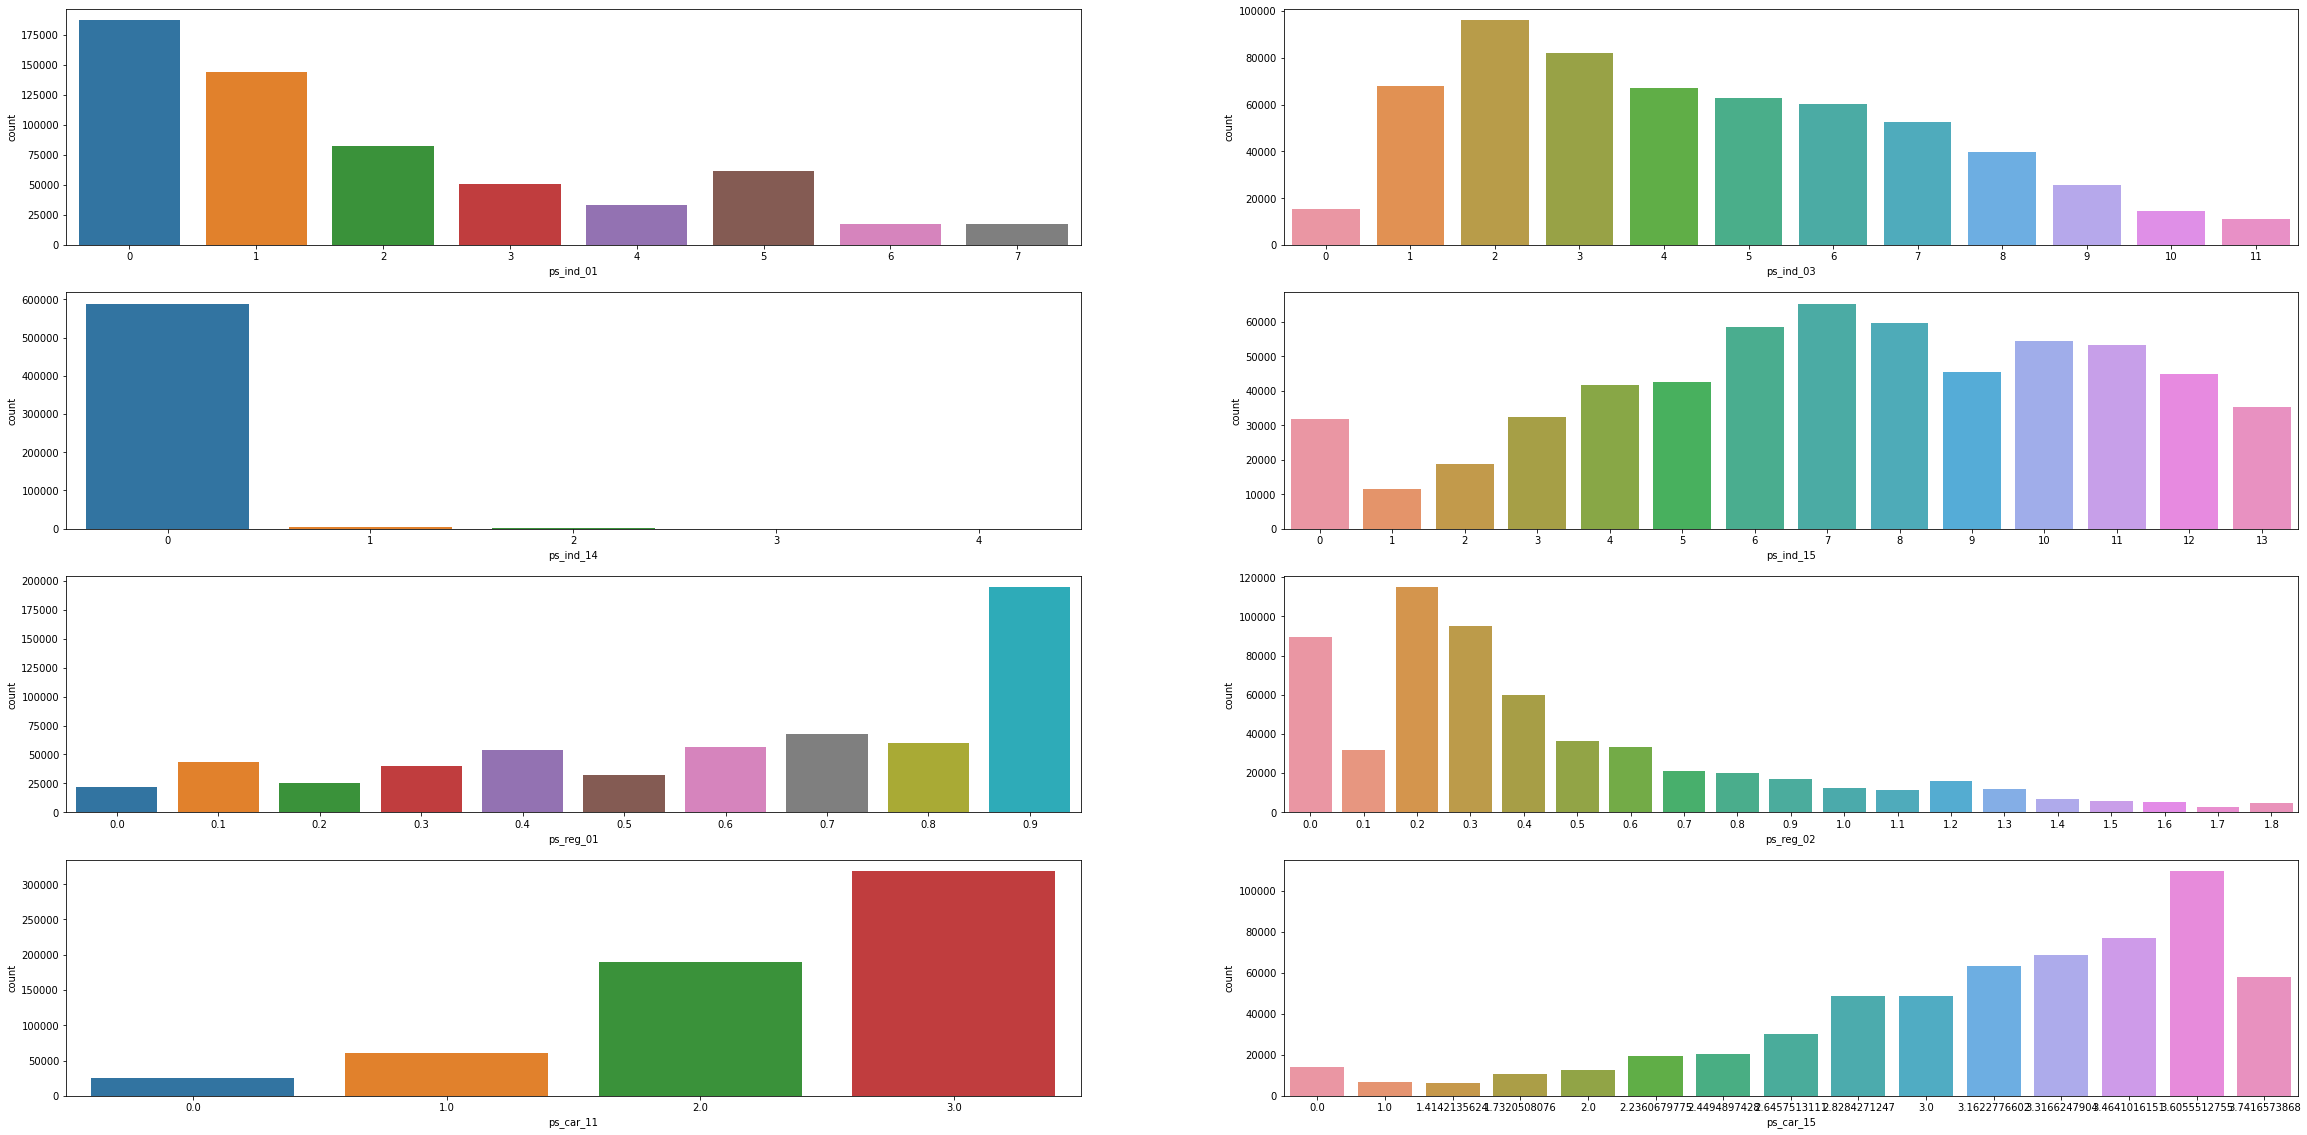

In [338]:
fig,ax = plt.subplots(4, 2, figsize=(40,20))
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8 = ax.flatten()
sns.countplot(data=train,x='ps_ind_01', ax=ax1)
sns.countplot(data=train,x='ps_ind_03', ax=ax2)
sns.countplot(data=train,x='ps_ind_14', ax=ax3)
sns.countplot(data=train,x='ps_ind_15', ax=ax4)
sns.countplot(data=train,x='ps_reg_01', ax=ax5)
sns.countplot(data=train,x='ps_reg_02', ax=ax6)
sns.countplot(data=train,x='ps_car_11', ax=ax7)
sns.countplot(data=train,x='ps_car_15', ax=ax8)

In [339]:
float_features = [col for col in train.columns if col not in category_columns]
float_features.remove('id')
float_features

['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14']

In [340]:
train['ps_reg_03'].describe()

count    595212.000000
mean          0.846950
std           0.328237
min           0.061237
25%           0.633936
50%           0.720677
75%           1.000000
max           4.037945
Name: ps_reg_03, dtype: float64

In [341]:
train['ps_car_12'].describe()

count    595212.000000
mean          0.379947
std           0.058300
min           0.100000
25%           0.316228
50%           0.374166
75%           0.400000
max           1.264911
Name: ps_car_12, dtype: float64

In [342]:
train['ps_car_13'].describe()

count    595212.000000
mean          0.813265
std           0.224588
min           0.250619
25%           0.670867
50%           0.765811
75%           0.906190
max           3.720626
Name: ps_car_13, dtype: float64

In [343]:
train['ps_car_14'].describe()

count    595212.000000
mean          0.373748
std           0.044078
min           0.109545
25%           0.353553
50%           0.368782
75%           0.396485
max           0.636396
Name: ps_car_14, dtype: float64

ВЫБРОСЫ!

In [344]:
train.dtypes


id                  int64
target           category
ps_ind_01        category
ps_ind_02_cat    category
ps_ind_03        category
ps_ind_04_cat    category
ps_ind_05_cat    category
ps_ind_06_bin    category
ps_ind_07_bin    category
ps_ind_08_bin    category
ps_ind_09_bin    category
ps_ind_10_bin    category
ps_ind_11_bin    category
ps_ind_12_bin    category
ps_ind_13_bin    category
ps_ind_14        category
ps_ind_15        category
ps_ind_16_bin    category
ps_ind_17_bin    category
ps_ind_18_bin    category
ps_reg_01        category
ps_reg_02        category
ps_reg_03         float64
ps_car_01_cat    category
ps_car_02_cat    category
ps_car_03_cat    category
ps_car_04_cat    category
ps_car_05_cat    category
ps_car_06_cat    category
ps_car_07_cat    category
ps_car_08_cat    category
ps_car_09_cat    category
ps_car_10_cat    category
ps_car_11_cat    category
ps_car_11        category
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_car_15   

In [345]:
for col in num_columns:
  q_1, q_3 = np.percentile(train[col],[25,75])
  q_f, q_l = np.percentile(train[col],[1,99])
  iqr = q_3 - q_1
  left, right = q_1 - (iqr * 1.5), q_3 + (iqr * 1.5)
  print(col, left, right, q_f, q_l)

ps_reg_03 0.08484029175000007 1.54909582495 0.4183300133000001 1.8521946442
ps_car_12 0.19056941500000002 0.525658351 0.3155946768 0.5656854249000001
ps_car_13 0.31788087655 1.2591761161500001 0.44830050977400004 1.6176168955090011
ps_car_14 0.2891566484999999 0.4608812941000002 0.2887905816 0.5234500931


In [346]:
for col in num_columns:
  q_1, q_3 = np.percentile(train[col],[25,75])
  q_f, q_l = np.percentile(train[col],[1,99])
  iqr = q_3 - q_1
  left, right = q_1 - (iqr * 1.5), q_3 + (iqr * 1.5)
  print(col, left, right, q_f, q_l)
  train[col].loc[train[col] < left] = q_f
  train[col].loc[train[col] > right] = q_l

ps_reg_03 0.08484029175000007 1.54909582495 0.4183300133000001 1.8521946442
ps_car_12 0.19056941500000002 0.525658351 0.3155946768 0.5656854249000001
ps_car_13 0.31788087655 1.2591761161500001 0.44830050977400004 1.6176168955090011
ps_car_14 0.2891566484999999 0.4608812941000002 0.2887905816 0.5234500931


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [347]:
for col in num_columns:
  q_1, q_3 = np.percentile(test[col],[25,75])
  q_f, q_l = np.percentile(test[col],[1,99])
  iqr = q_3 - q_1
  left, right = q_1 - (iqr * 1.5), q_3 + (iqr * 1.5)
  print(col, left, right, q_f, q_l)
  test[col].loc[test[col] < left] = q_f
  test[col].loc[test[col] > right] = q_l

ps_reg_03 0.08156262285000004 1.55455860645 0.41907636539999993 1.8521946442
ps_car_12 0.19056941500000002 0.525658351 0.3155946768 0.5656854249000001
ps_car_13 0.3188870638624999 1.2584782365625 0.4485283558 1.6172399231399996
ps_car_14 0.2891566484999999 0.4608812941000002 0.2887905816 0.5234500931


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

One hot encoding

In [348]:
len(category_columns)

34

In [349]:
def one_hot_enc(train, test, columns):
  category_columns = columns
  train_len = train.shape[0]  
  data = pd.concat([train, test], ignore_index=True)
  more_than_two_uniques = []
  new_features = {}

  print('Categorical features:', len(columns))

  for col in category_columns:
    if data[col].nunique() > 2:
      more_than_two_uniques.append(col)
      new_features[col] = 'ohe_' + col
    
  data = pd.get_dummies(data, prefix=new_features, columns=more_than_two_uniques, drop_first=True)
  train = data.loc[:train_len - 1]
  test = data.loc[train_len:]

  print('Train shape', train.shape)
  print('Test shape', test.shape)

  return train, test

In [350]:
enc_train, enc_test = one_hot_enc(train, test, category_columns)

Categorical features: 34
Train shape (595212, 257)
Test shape (892816, 257)


In [355]:
list(enc_train.dtypes == 'float64').count(True)

4

In [351]:
X = enc_train.drop(['target', 'id'], axis=1)
y = enc_train['target'].astype('category')
x_test = enc_test.drop(['target','id'],axis=1)

In [357]:
logreg = LogisticRegression(class_weight='balanced')
param = {'C':[0.001, 0.0015, 0.002, 0.025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.01, 0.1, 0.5, 1]}
clf = GridSearchCV(logreg, param, scoring='roc_auc', refit=True, cv=5)
clf.fit(X,y)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Best roc_auc: 0.6351, with best C: 0.005


In [358]:
seed = 42

In [360]:
kf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
sum_of_preds = 0
cross_val_scores = []
for train_index, test_index in kf.split(X, y):    
    x_train, x_val = X.loc[train_index], X.loc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    
    lr = LogisticRegression(class_weight='balanced', C=0.005, max_iter=1000)
    lr.fit(x_train, y_train)
    pred_test = lr.predict_proba(x_val)[:,1]
    score = roc_auc_score(y_val,pred_test)
    print('roc_auc_score', score)
    cross_val_scores.append(score)
    sum_of_preds += lr.predict_proba(x_test)[:,1]

roc_auc_score 0.6407272667930741
roc_auc_score 0.6342209944766478
roc_auc_score 0.6354220707581391
roc_auc_score 0.6365818435421535
roc_auc_score 0.6289999067845222


In [362]:
confusion_matrix(y_val, lr.predict(x_val))

array([[71725, 42978],
       [ 1916,  2423]])

In [363]:
np.mean(cross_val_scores)

0.6351904164709075

Text(0.5, 0, 'FPR')

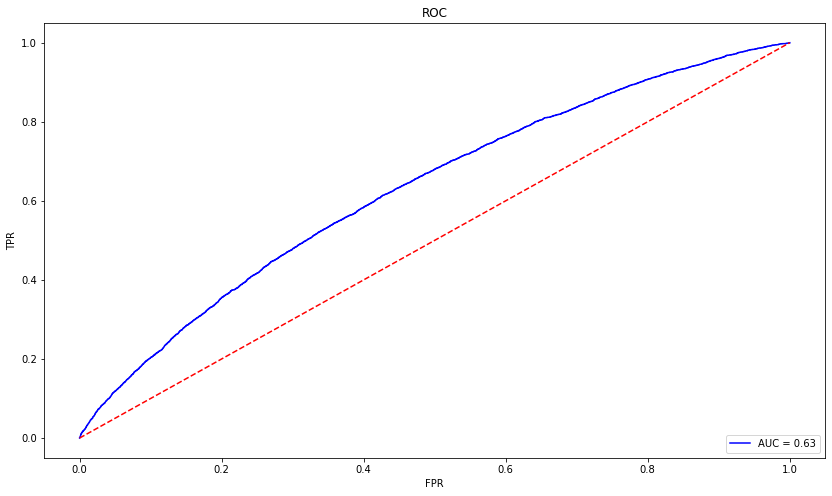

In [364]:
fpr, tpr, threshold = roc_curve(y_val, lr.predict_proba(x_val)[:,1])
auc_val = auc(fpr, tpr)

plt.figure(figsize=(14,8))
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_val)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('TPR')
plt.xlabel('FPR')

In [366]:
submit = pd.DataFrame({'id':test['id'], 'target':sum_of_preds / 5})
submit.to_csv('porto_logreg.csv', index=False) 
!cp porto_logreg.csv "/content/drive/MyDrive/Courses/RS School ML/ml-intro-2021/5_classification_linear_knn"

Скор на каггле 0.26865